In [3]:
import gp_lib 
import importlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
def reload():
    global gp_lib
    gp_lib = importlib.reload(gp_lib)

In [37]:
reload()

In [7]:
gp_lib.DataStore.load_dataset(pd.read_csv('sotonmet.txt'))

In [56]:
data = gp_lib.DataStore()
def fit_predict(data, kern, nvar, title=None, savename=None):
    gpr = gp_lib.Gp(kern, nvar)
    yt, yvar = gpr.fit_predict(data.X, data.y, data.Xt)

    test_logp = gp_lib.test_gain(data.yt, yt, yvar)
    # print(f'{train_logp=:.3e}, {test_logp=:.3e}')
    data.apply_result(yt,yvar)  
    gp_lib.plot(data.df, title, savename)


    print(f'{test_logp=:.3e}')


    return test_logp

# Exploring kernels


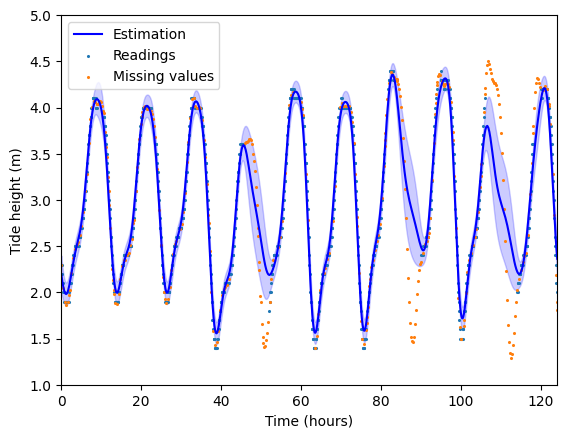

test_logp=-3.803e+02


-380.2799076883089

In [58]:
nvar = 1e-1
kern = gp_lib.Rbf(nvar, 0.1,0.05)
fit_predict(data,kern,nvar, savename='rbf.png')

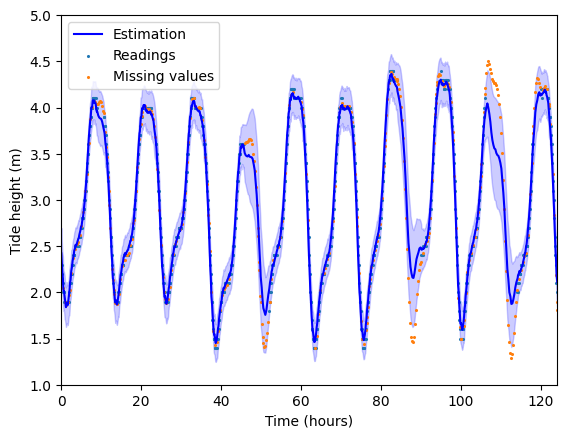

test_logp=2.081e+02


208.11913296479315

In [60]:
kern = gp_lib.PeriodicRbfOr(nvar, 0.1, 0.05, 0.1, 0.05,0.354)
fit_predict(data,kern,nvar, savename='rbfperiodor.png')

# # Optimising kernels


In [9]:
nvar = 1e-1
kern = gp_lib.Periodic(nvar, 1.,1.,1.)
fit = kern.optim(data.X,data.y, [1., 5e-2, 0.354])



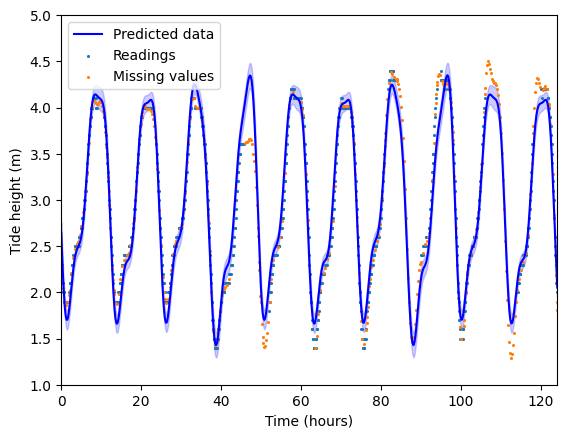

nan

In [88]:
fit_predict(data, kern, nvar,savename='period_opt.png')

In [32]:
nvar = 1e-1
kern = gp_lib.PeriodicRbfAnd(nvar, 1.,1.,1.,1.)
fit = kern.optim(data.X,data.y, [1., 5e-2, 5e-2, 0.354])
train_logp = -fit.fun

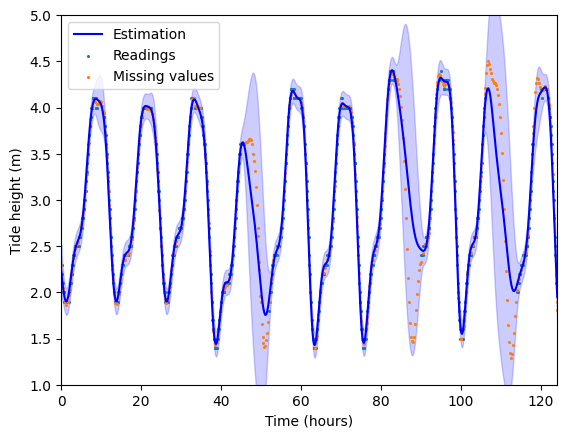

3.247e+02


In [35]:
test_logp = fit_predict(data, kern, nvar,savename='rbfper_and_opt.png')
print(f'{test_logp:.3e}')

# 10 trial random initialisation of RBFxPeriod kernel

In [32]:
nvar = 1e-1
kern = gp_lib.PeriodicRbfAnd(nvar, 1.,1.,1.,1.)
fit = kern.optim(data.X,data.y, [1., 5e-2, 5e-2, 0.354], mode='rand_start', init_bounds=[[1e-3, 2], [1e-3, 0.5],[1e-3, 0.5], [0.2, 0.6]], opt_bounds=[(None,None),(None,None),(None,None),np.log((0.3,0.4))], n_trials=10)
kparams,train_logp = fit[0]


In [33]:
kparam_list, logps = zip(*fit)
kparam_list = [[np.round(kpp, 6) for kpp in kp] for kp in kparam_list]

In [42]:
opt_result= pd.DataFrame({k:v for k,v in zip(['scale', 'len_rbf', 'len_per', 'period'], zip(*kparam_list))} | {'neg loglikelihood':logps})

In [34]:
kparam_list

[[1.793557, 1.620717, 1.226422, 0.353392],
 [1.133438, 0.051622, 1652.882458, 0.4],
 [1.133514, 0.051624, 1337.748745, 0.4],
 [1.133422, 0.051622, 699.344605, 0.4],
 [1.133412, 0.051622, 662.813011, 0.4],
 [1.133043, 0.051621, 615.473175, 0.4],
 [1.13341, 0.051622, 411.719579, 0.4],
 [0.944859, 0.547806, 0.007529, 0.399064],
 [0.96746, 0.350288, 0.005355, 0.303411]]

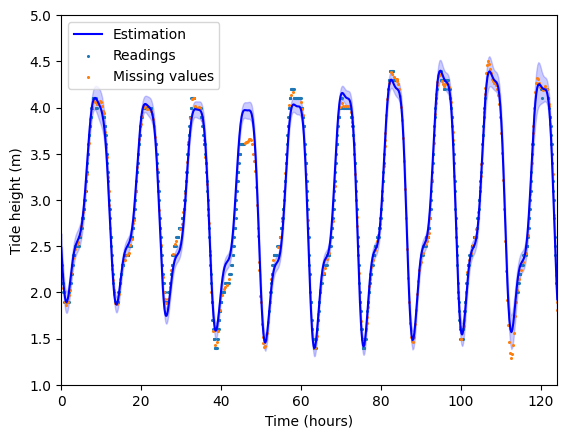

test_logp=-2.875e+02


In [51]:
best_kparams = [1.793557, 1.620717, 1.226422, 0.353392]
nvar = 1e-1
kern = gp_lib.PeriodicRbfAnd(nvar, *best_kparams)
test_logp = fit_predict(data, kern, nvar, savename='10trial_rbfxper_opt.png')
print(f'{test_logp=:.3e}')

# AR predictions

In [53]:
predictions = gp_lib.ar_gp_prediction(data.df, kern)

/Users/kaye/Library/CloudStorage/OneDrive-Nexus365/AIMS/Inference/gp_lib.py:340: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt.margins(x=0)


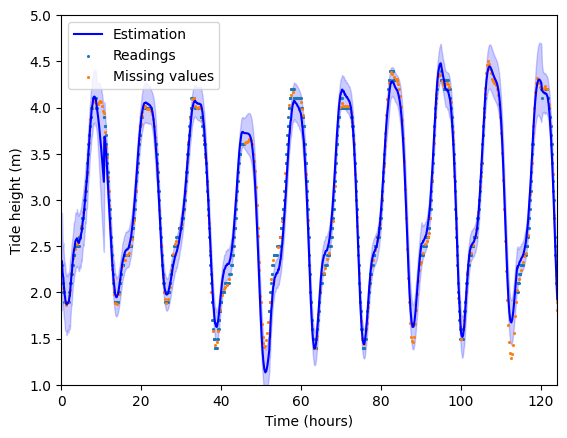

In [54]:
gp_lib.plot_lookahead(predictions, 'tmp.png')